In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

Sequence problems: an ordered sequence of data points shares a single lable - emphasis on being ordered

In [2]:
points, directions = generate_sequences(n=128, seed=13)

Recurrent neural network are all about producting a hidden state that best represents a sequence

In [3]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

In [4]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

In [6]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [7]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [8]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [10]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [11]:
tx = linear_input(X[:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

In [12]:
adding = th + tx
adding

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

In [13]:
torch.tanh(adding)

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [14]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [15]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
    out = rnn_cell(X[i: i+1], hidden)
    print(out)
    hidden = out

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>)
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>)
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>)


In [16]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

In [19]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

torch.Size([3, 4, 2])

In [20]:
permuted_batch = batch.permute(1,0,2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [21]:
torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [23]:
(out[-1] == final_hidden).all()

tensor(True)

In [25]:
batch_hidden = final_hidden.permute(1,0,2)
batch_hidden.shape

torch.Size([3, 1, 2])

In [26]:
torch.manual_seed(19)
rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
out, final_hidden = rnn_batch_first(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

In [27]:
torch.manual_seed(19)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

In [30]:
torch.manual_seed(19)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

In [31]:
test_points, test_directions = generate_sequences(seed=19)

In [32]:
train_data = TensorDataset(torch.as_tensor(points).float(), torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1,1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [33]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.clasifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.clasifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [34]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [35]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

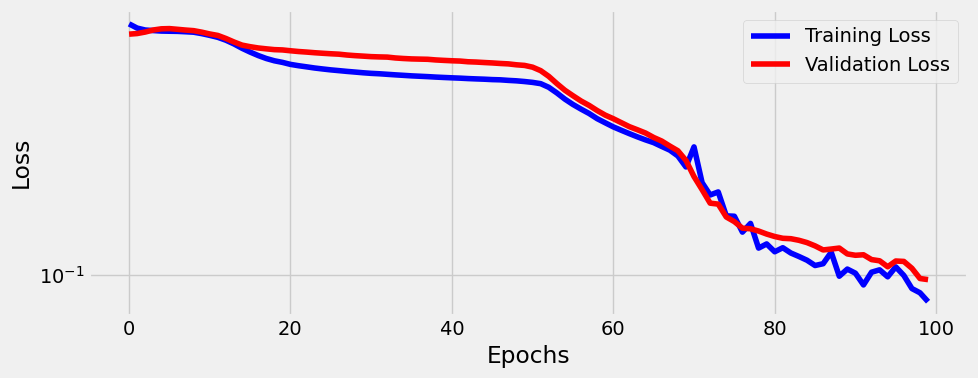

In [36]:
fig = sbs_rnn.plot_losses()

In [37]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

In [38]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [40]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']

In [41]:
Wxr, Wxz, Wxn = Wx.split(hidden_dim, dim=0)
bxr, bxz, bxn = bx.split(hidden_dim, dim=0)

Whr, Whz, Whn = Wh.split(hidden_dim, dim=0)
bhr, bhz, bhn = bh.split(hidden_dim, dim=0)

Wxr, bxr

(tensor([[-0.0930,  0.0497],
         [ 0.4670, -0.5319]]),
 tensor([-0.4316,  0.4019]))

In [43]:
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input
# reset gate -red
r_hidden, r_input = linear_layers(Wxr, bxr, Whr, bhr)
# update gate - blue
z_hidden, z_input = linear_layers(Wxz, bxz, Whz, bhz)
# candidate state - black
n_hidden, n_input = linear_layers(Wxn, bxn, Whn, bhn )

In [46]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        # Simple RNN
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.clasifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.clasifier(last_output)

        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [48]:
torch.manual_seed(21)
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [49]:
sbs_gru = StepByStep(model, loss, optimizer)
sbs_gru.set_loaders(train_loader, test_loader)
sbs_gru.train(100)

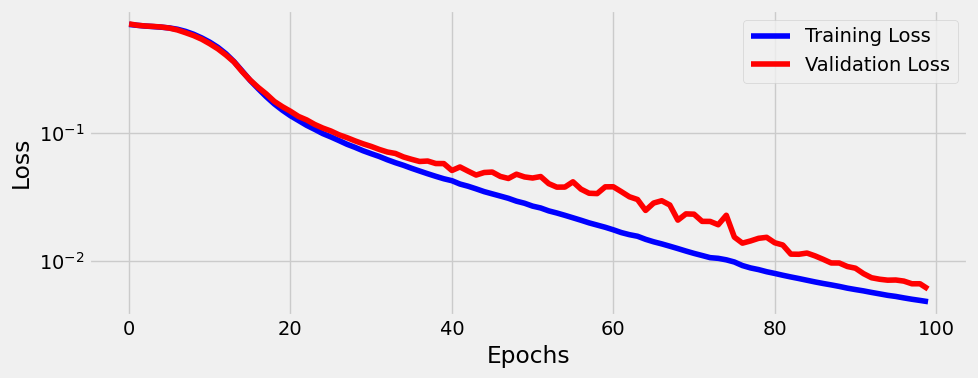

In [50]:
fig = sbs_gru.plot_losses()

In [51]:
StepByStep.loader_apply(test_loader, sbs_gru.correct)

tensor([[53, 53],
        [75, 75]])

In [52]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True)
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)

        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [53]:
torch.manual_seed(21)
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [54]:
sbs_lstm = StepByStep(model, loss, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

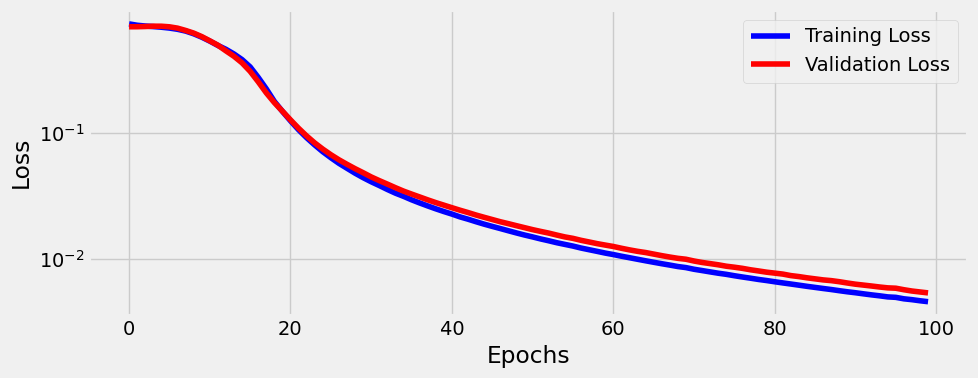

In [55]:
fig = sbs_lstm.plot_losses()

In [56]:
StepByStep.loader_apply(test_loader, sbs_lstm.correct)

tensor([[53, 53],
        [75, 75]])

## Variable-Length Sequences

In [57]:
x0 = points[0]
x1 = points[1][2:]
x2 = points[2][1:]

x0.shape, x1.shape, x2.shape

((4, 2), (2, 2), (3, 2))

In [59]:
all_seqs = [x0, x1, x2]

In [60]:
seq_tensors = [torch.as_tensor(seq).float() for seq in all_seqs]
padded = rnn_utils.pad_sequence(seq_tensors, batch_first=True)
padded

tensor([[[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]],

        [[-1.0911,  0.9254],
         [-1.0771, -1.0414],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.1247, -0.9683],
         [ 0.8182, -0.9944],
         [ 1.0081,  0.7680],
         [ 0.0000,  0.0000]]])

In [61]:
torch.manual_seed(11)
rnn = nn.RNN(2,2, batch_first=True)

In [62]:
output_padded, hidden_padded = rnn(padded)
output_padded

tensor([[[-0.6388,  0.8505],
         [-0.4215,  0.8979],
         [ 0.3792,  0.3432],
         [ 0.3161, -0.1675]],

        [[ 0.2911, -0.1811],
         [ 0.3051,  0.7055],
         [ 0.0052,  0.5819],
         [-0.0642,  0.6012]],

        [[ 0.3385,  0.5927],
         [-0.3875,  0.9422],
         [-0.4832,  0.6595],
         [-0.1007,  0.5349]]], grad_fn=<TransposeBackward1>)

In [63]:
hidden_padded.permute(1,0,2)

tensor([[[ 0.3161, -0.1675]],

        [[-0.0642,  0.6012]],

        [[-0.1007,  0.5349]]], grad_fn=<PermuteBackward0>)

In [65]:
packed = rnn_utils.pack_sequence(seq_tensors, enforce_sorted=False)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))